In [1]:
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
import spatialpy
import numpy
import matplotlib.pyplot as plt


In [3]:
class All(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return True

class Walls(spatialpy.Geometry):
    ''' Outside of the unit square'''
    def inside(self, x, on_boundary):
        if x[0] < 0.0 or x[0] > 1.0 or \
           x[1] < 0.0 or x[1] > 1.0:
            return True
        return False

In [4]:
class Lid_Driven_Cavity(spatialpy.Model):
    """ Lid driven cavity problem
    Description: box with Dirichlet boundary conditions in all 4 walls
    Top wall: moves with constant velocity Vo
    All other walls: stationary (no-slip)
    Wall lengths: height = 1, width = 1 (2D case)
  
              vx=Vo, vy=0
              __ __ __ __
             |           |
             |           |
    vx=vy=0  |           |  vx=vy=0
             |           |
             |__ __ __ __|
             
                vx=vy=0
    
    """

    def __init__(self, model_name="lid_driven_cavity"):
        spatialpy.Model.__init__(self,model_name)
        
        # System constants
        Vo = 1.              # lid velocity
        nxF,nyF = 50,50      # number of fluid particles in x and y-direction
        nu  = 0.01           # fluid viscosity
        L   = 1.             # characteristic lenght of the cavity (= width = height)
        nW  = 3              # number of wall points
        rho0 = 1.            # reference fluid density
        c0  = 10.            # reference speed of sound (typically, 10* max velocity)
        P0  = rho0* c0**2    # reference pressure
        
        # Discretization
        nxTot = nxF + 2*nW # total number of particles in x-direction (including walls)
        nyTot = nyF + 2*nW # total number of particles in y-direction (including walls)
        
        # Compute domain bounds (including the boundary)
        dx,dy = L/(nxF-1),L/(nyF-1)
        xLim = ((0-(nW-1)*dx),1+(nW-1)*dx)
        yLim = ((0-(nW-1)*dy),1+(nW-1)*dy)
        
        # Compute volume and mass per particle
        vol = (xLim[1]-xLim[0])*(yLim[1]-yLim[0])*1.0 # in 2D simulations, consider z-lenght = 1
        mPP = rho0*vol/(nxTot*nyTot)                   # density * total volume / total number of particles
        
        # Create mesh object
        print("xlim={0} ylim={1} nx={2} ny={3}".format(xLim, yLim, nxTot,nyTot))
        self.domain = spatialpy.Domain.create_2D_domain(
            xLim ,yLim , nxTot, nyTot, 
            type_id=1, mass=mPP, nu = nu, rho0 = rho0, c0 = c0, P0 = P0,  fixed=False)
        
        # Define Subdomains
        self.set_type(All(), 1, mass = mPP, fixed=False)  # total subdomain, type 1
        self.set_type(Walls(), 2, mass = mPP, fixed=True) # lid subdomain, type 2

        # Boundary conditions
        # They should go here... define subdomain top with velocity Vo
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            ymin     = yLim[1]-(nW-1)*dy, # top 3 rows of particles
            property = 'v',
            value    = [1.0, 0.0, 0.0] 
        ))
        
        # Time span
        #self.timespan(numpy.linspace(0,5,1000), timestep_size=5e-3)
        self.timespan(numpy.linspace(0,0.01,1000), timestep_size=1e-5)
        self.staticDomain = False

In [5]:
# Creates the model object
model = Lid_Driven_Cavity()

xlim=(-0.04081632653061224, 1.0408163265306123) ylim=(-0.04081632653061224, 1.0408163265306123) nx=56 ny=56


In [6]:
# Run the model object
%time result = model.run()

CPU times: user 35.1 ms, sys: 15.5 ms, total: 50.6 ms
Wall time: 1min 44s


In [7]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(key='type',index=0,time=0):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
    else:
        d = data[key]
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(time))
    #plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
    #plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.grid(linestyle='--', linewidth=1)

    
def plot_all(key='type'):
    for i,t in enumerate(result.get_timespan()):
        plot_step(i,key)

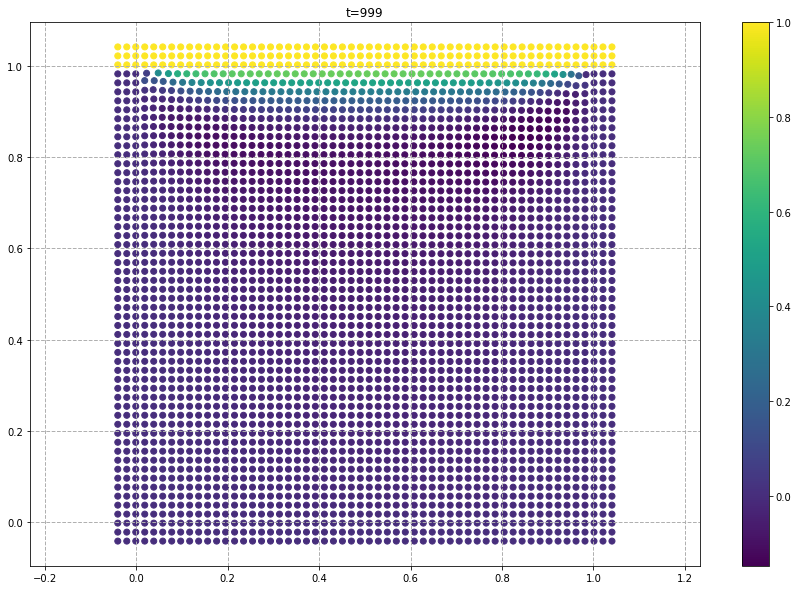

In [8]:
# Plot velocity (index 0, i.e., vx) at timestep 10
plot_step('v',index=0,time=999)

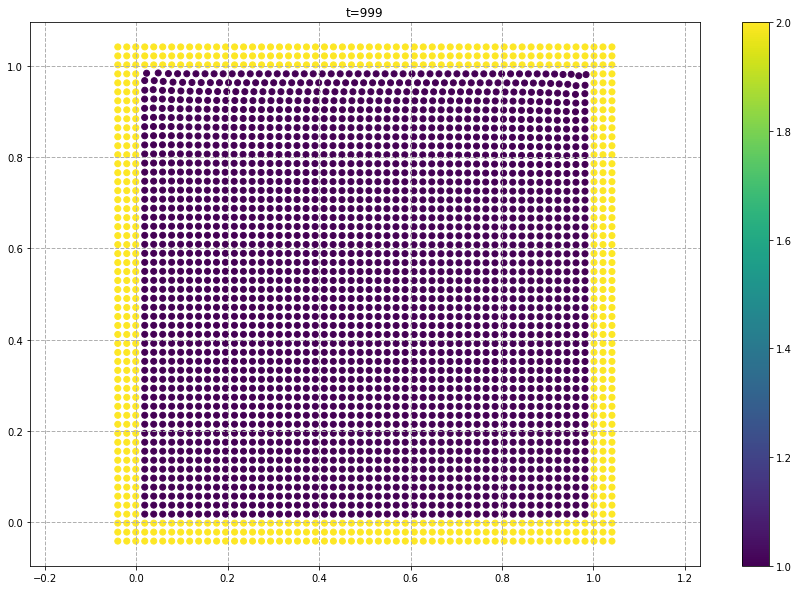

In [9]:
# Plot velocity (index 0, i.e., vx) at timestep 10
plot_step('type',index=0,time=999)

In [10]:
result.plot_property("v", animated=True)